Libraries imported successfully.

Dataset 'train.json' loaded successfully.
Dataset shape: (39774, 3)

First 5 rows of the dataset:
      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

Missing values check:
id             0
cuisine        0
ingredients    0
dtype: int64


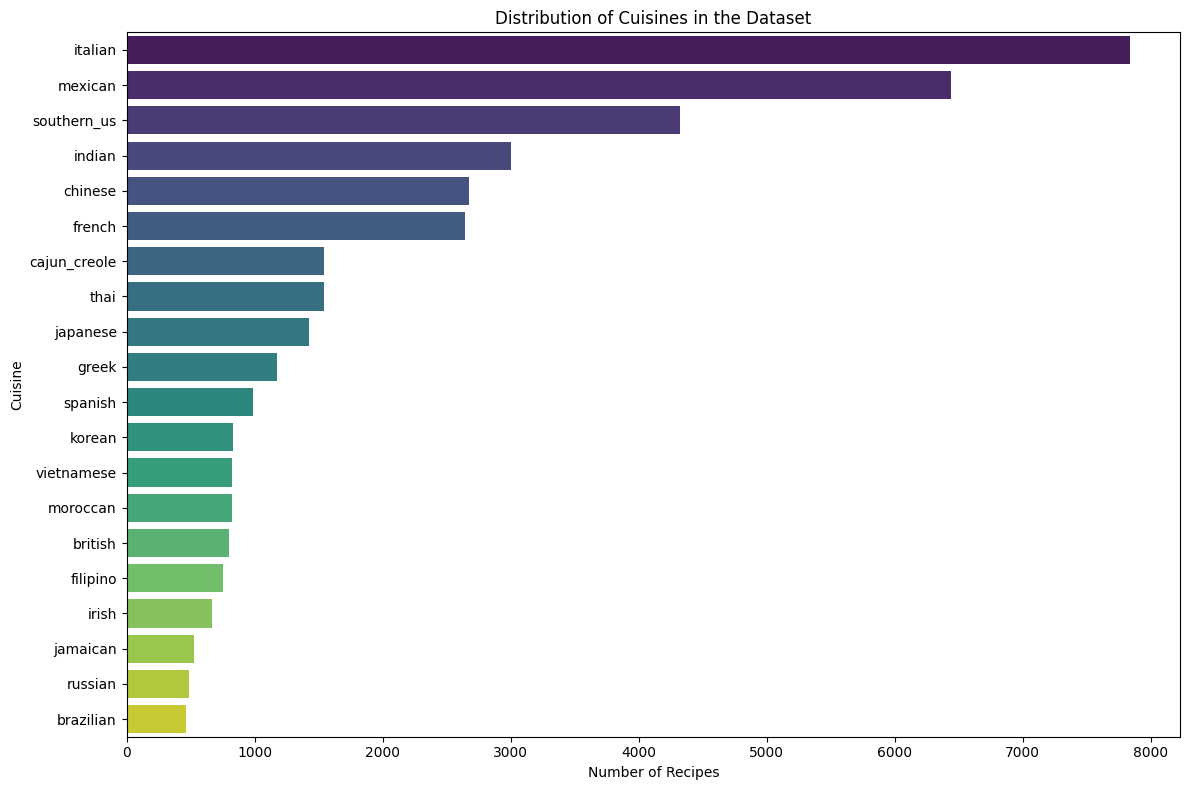


Shape of the feature matrix (X): (39774, 3010)
Number of unique ingredients (features): 3010

Training set size: 29830
Testing set size: 9944

Model training complete.

--- Inference Example ---
The predicted cuisine for the ingredients ['tomato', 'pasta', 'olive oil', 'garlic', 'feta cheese'] is: **italian**
-------------------------

Model Accuracy: 0.7194

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.54      0.36      0.43       117
     british       0.30      0.38      0.34       201
cajun_creole       0.56      0.75      0.64       386
     chinese       0.72      0.87      0.79       668
    filipino       0.69      0.41      0.51       189
      french       0.49      0.53      0.51       662
       greek       0.66      0.60      0.63       294
      indian       0.83      0.88      0.85       751
       irish       0.68      0.35      0.46       167
     italian       0.82      0.78      0.80      1960
    jamaican       

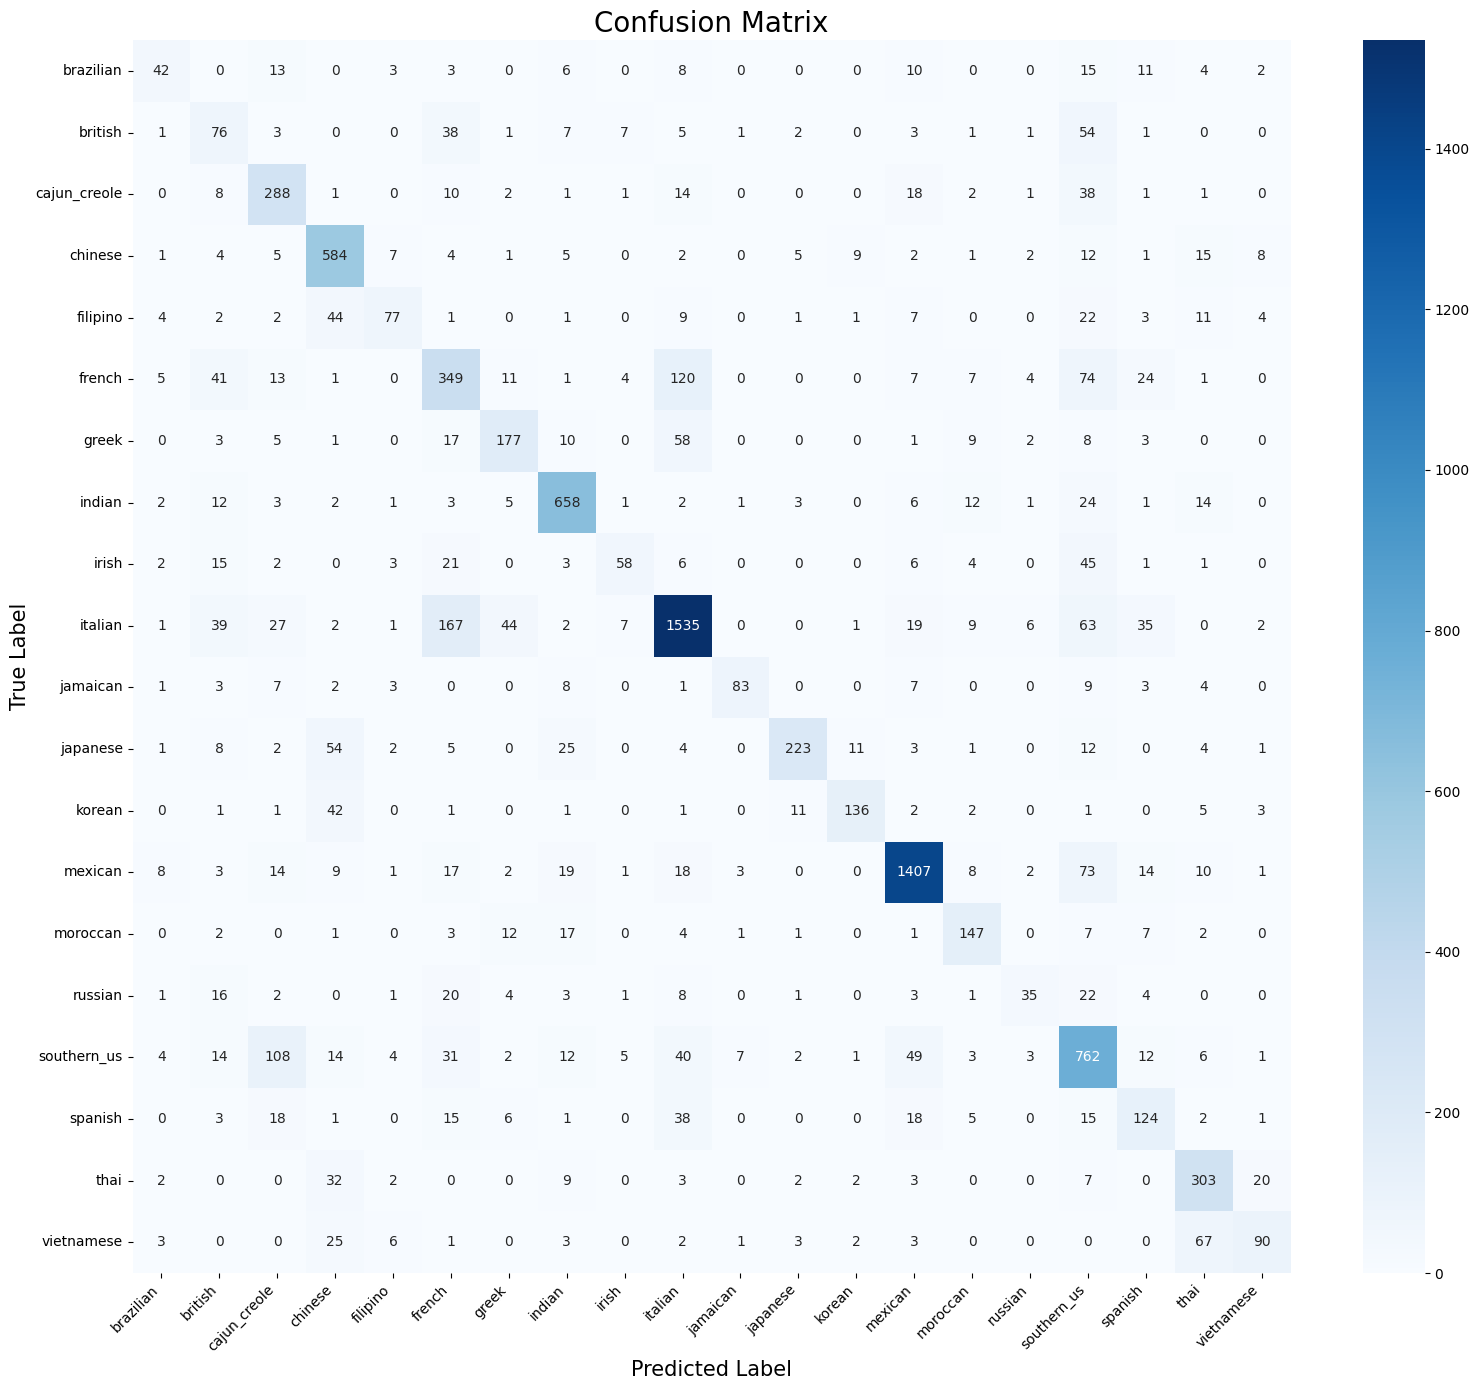

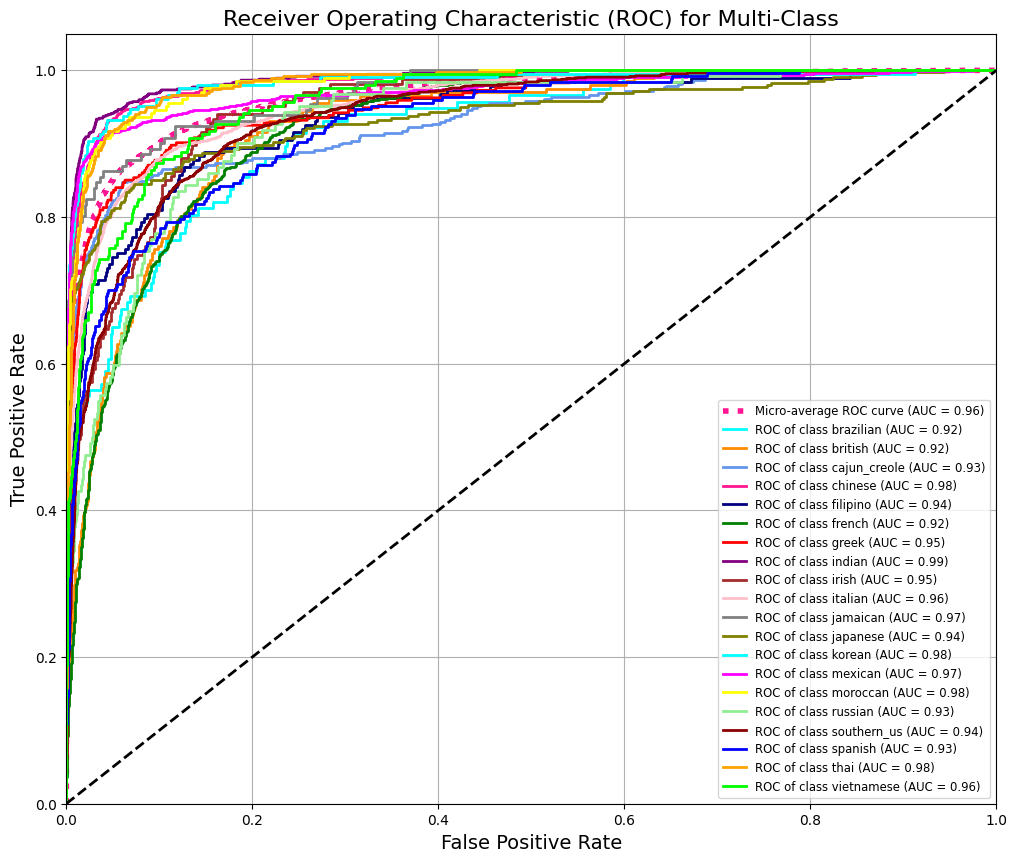

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

print("Libraries imported successfully.")

try:
    with open('/kaggle/input/recipe-ingredients-dataset/train.json') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    print("\nDataset 'train.json' loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("\nError: 'train.json' not found. Please download it from Kaggle: https://www.kaggle.com/c/whats-cooking/data")
    dummy_data = [
        {'id': 1, 'cuisine': 'italian', 'ingredients': ['tomato', 'basil', 'pasta', 'cheese']},
        {'id': 2, 'cuisine': 'mexican', 'ingredients': ['chili', 'beans', 'tortilla', 'avocado']},
        {'id': 3, 'cuisine': 'italian', 'ingredients': ['olive oil', 'garlic', 'pasta']},
        {'id': 4, 'cuisine': 'mexican', 'ingredients': ['salsa', 'jalapeno', 'tortilla']},
        {'id': 5, 'cuisine': 'indian', 'ingredients': ['curry', 'rice', 'turmeric']},
        {'id': 6, 'cuisine': 'indian', 'ingredients': ['lentils', 'ginger', 'garam masala']}
    ]
    df = pd.DataFrame(dummy_data)
    print("Using a small dummy dataset for demonstration purposes.")


print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nMissing values check:")
print(df.isnull().sum())


plt.figure(figsize=(12, 8))
sns.countplot(y='cuisine', data=df, order=df['cuisine'].value_counts().index, palette='viridis')
plt.title('Distribution of Cuisines in the Dataset')
plt.xlabel('Number of Recipes')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.show()


df['ingredients_str'] = df['ingredients'].apply(' '.join)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['ingredients_str'])
y = df['cuisine']

print(f"\nShape of the feature matrix (X): {X.shape}")
print(f"Number of unique ingredients (features): {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

model = MultinomialNB()
model.fit(X_train, y_train)
print("\nModel training complete.")


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


def predict_cuisine(ingredients_list):
    """Predicts the cuisine for a given list of ingredients."""
    ingredients_text = ' '.join(ingredients_list)
    ingredients_vectorized = vectorizer.transform([ingredients_text])
    prediction = model.predict(ingredients_vectorized)
    return prediction[0]


new_recipe = ['tomato', 'pasta', 'olive oil', 'garlic', 'feta cheese']
predicted_cuisine = predict_cuisine(new_recipe)
print(f"\n--- Inference Example ---")
print(f"The predicted cuisine for the ingredients {new_recipe} is: **{predicted_cuisine}**")
print("-------------------------\n")



accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}\n")


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=model.classes_))



cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes = len(model.classes_)

fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'lightgreen', 'darkred', 'blue', 'orange', 'lime'])

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC of class {model.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()